Loading data...
Creating in-memory SQLite database...
Executing query...
Data loaded successfully! Total rows: 54521

运行标准R2T算法...
开始求解tau=2的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 2000.00
- u_k总和: 2000.00
- 非零u_k数量: 1000
- u_k最大值: 2.00
R2T - tau=2: Q*=2000.00, noisy Q*=1643.63
开始求解tau=4的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 4000.00
- u_k总和: 4000.00
- 非零u_k数量: 1000
- u_k最大值: 4.00
R2T - tau=4: Q*=4000.00, noisy Q*=3165.33
开始求解tau=8的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 8000.00
- u_k总和: 8000.00
- 非零u_k数量: 1000
- u_k最大值: 8.00
R2T - tau=8: Q*=8000.00, noisy Q*=6575.59
开始求解tau=16的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 16000.00
- u_k总和: 16000.00
- 非零u_k数量: 1000
- u_k最大值: 16.00
R2T - tau=16: Q*=16000.00, noisy Q*=13943.89
开始求解tau=32的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 32000.00
- u_k总和: 32000.00
- 非零u_k数量: 1000
- u_k最大值: 32.00
R2T - tau=32: Q*=32000.00, noisy Q*=25040.24
开始求解tau=64的优化问题，数据规模: (54521, 3)
求解完成。最优目标值 Q* = 64000.00
- u_k总和: 64000.00
- 非零u_k数量: 1000
- u_k最大值: 64.00
R2T - tau=64: Q*=

C:\Users\车睿佳\AppData\Local\Temp\ipykernel_11260\1795844277.py:267: UserWarning: Glyph 771 (\N{COMBINING TILDE}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_11260\1795844277.py:268: UserWarning: Glyph 771 (\N{COMBINING TILDE}) missing from current font.
  plt.savefig('r2t_vs_sr_main.png', dpi=300)
C:\anac\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 771 (\N{COMBINING TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


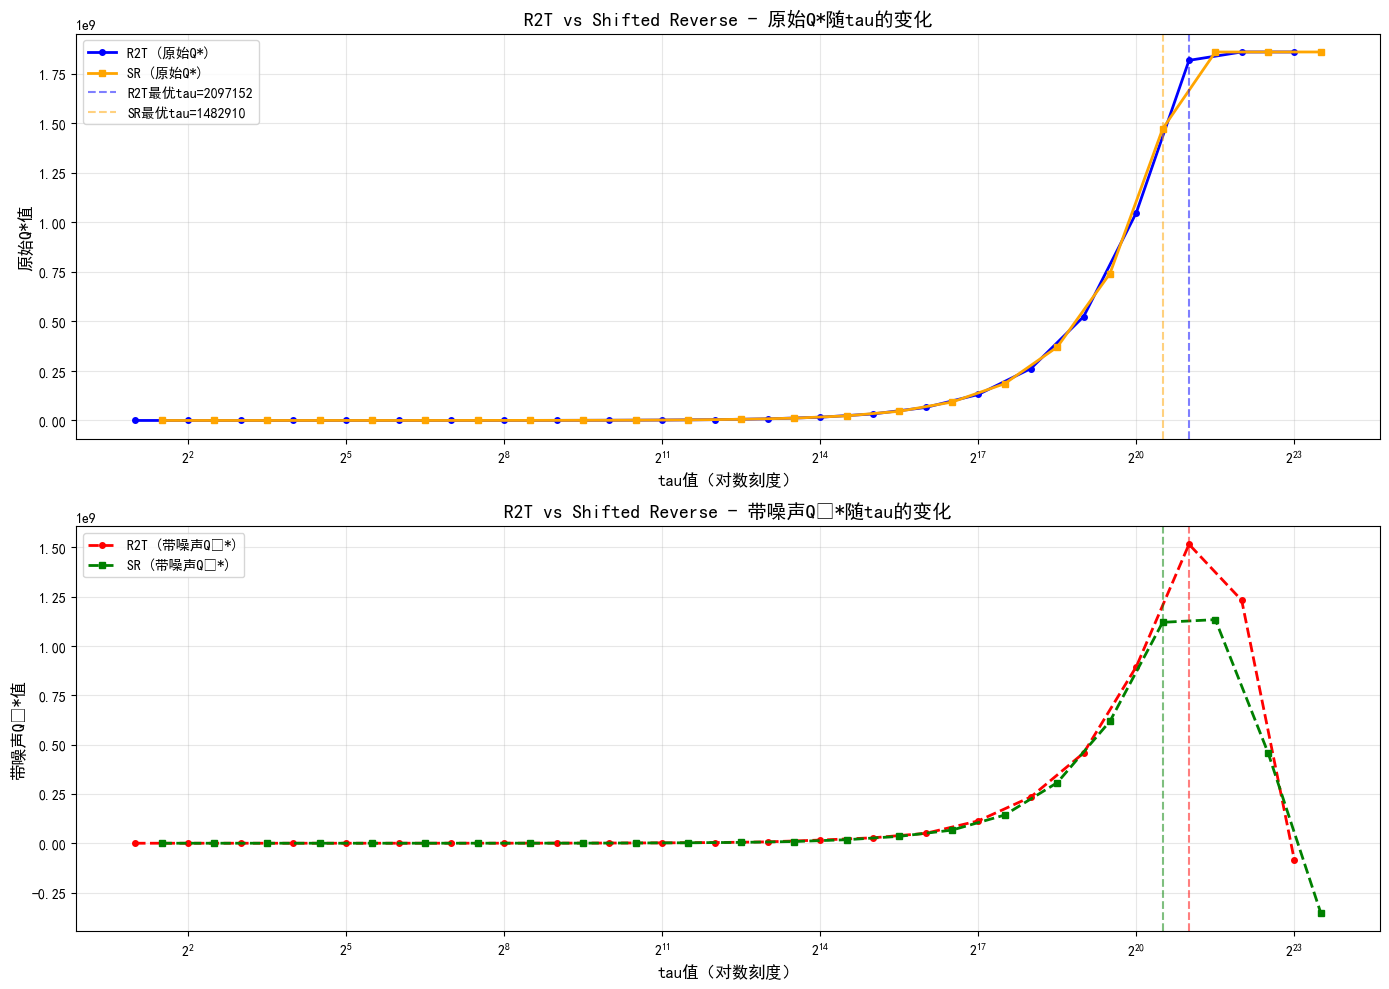

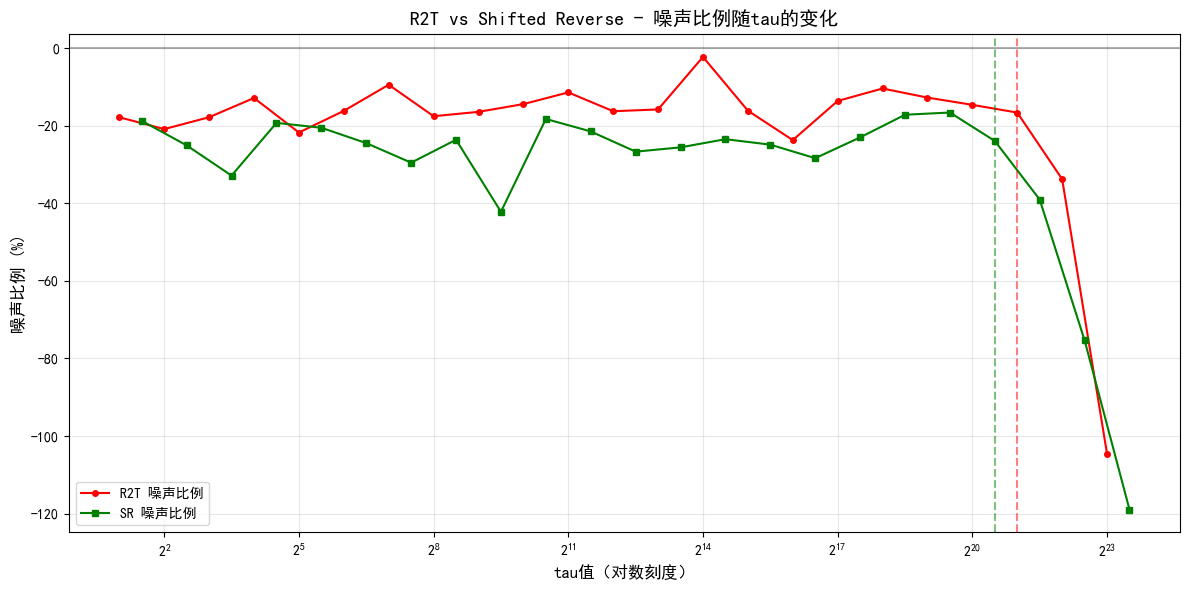

In [1]:
import sqlite3
import pandas as pd
from io import StringIO
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value
from numpy.random import laplace
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False

# ===================== 1. 数据加载（与原R2T一致） =====================
def load_tbl_to_dataframe(file_path, columns, skip_header=False):
    """加载TPC-H的.tbl文件到pandas DataFrame"""
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()
    if skip_header:
        lines = lines[1:]
    fixed_lines = [line[:-1] for line in lines if line]
    content = "\n".join(fixed_lines)
    df = pd.read_csv(StringIO(content), sep='|', header=None, names=columns, engine='python')
    return df

# 定义各表列名
customer_columns = [
    'C_CUSTKEY', 'C_NAME', 'C_ADDRESS', 'C_NATIONKEY',
    'C_PHONE', 'C_ACCTBAL', 'C_MKTSEGMENT', 'C_COMMENT'
]
supplier_columns = [
    'S_SUPPKEY', 'S_NAME', 'S_ADDRESS', 'S_NATIONKEY',
    'S_PHONE', 'S_ACCTBAL', 'S_COMMENT'
]
orders_columns = [
    'O_ORDERKEY', 'O_CUSTKEY', 'O_ORDERSTATUS', 'O_TOTALPRICE',
    'O_ORDERDATE', 'O_ORDERPRIORITY', 'O_CLERK', 'O_SHIPPRIORITY', 'O_COMMENT'
]
lineitem_columns = [
    'L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER',
    'L_QUANTITY', 'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX',
    'L_RETURNFLAG', 'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE',
    'L_RECEIPTDATE', 'L_SHIPINSTRUCT', 'L_SHIPMODE', 'L_COMMENT'
]

# 加载数据（请确保文件路径正确）
print("Loading data...")
customer_df = load_tbl_to_dataframe('customer.tbl', customer_columns)
supplier_df = load_tbl_to_dataframe('supplier.tbl', supplier_columns)
orders_df = load_tbl_to_dataframe('orders.tbl', orders_columns)
lineitem_df = load_tbl_to_dataframe('lineitem.tbl', lineitem_columns)

# 创建内存数据库
print("Creating in-memory SQLite database...")
conn = sqlite3.connect(':memory:')
customer_df.to_sql('Customer', conn, index=False)
supplier_df.to_sql('Supplier', conn, index=False)
orders_df.to_sql('Orders', conn, index=False)
lineitem_df.to_sql('Lineitem', conn, index=False)

# 执行查询
print("Executing query...")
query = """
SELECT Supplier.S_SUPPKEY, Customer.C_CUSTKEY, 
       L_EXTENDEDPRICE * (1 - L_DISCOUNT) as calculated_price
FROM Supplier, Lineitem, Orders, Customer
WHERE Supplier.S_SUPPKEY = Lineitem.L_SUPPKEY 
  AND Lineitem.L_ORDERKEY = Orders.O_ORDERKEY
  AND Orders.O_CUSTKEY = Customer.C_CUSTKEY
  AND Orders.O_ORDERDATE >= '1998-01-01'
"""
results_df = pd.read_sql_query(query, conn)
conn.close()

print(f"Data loaded successfully! Total rows: {len(results_df)}")

# ===================== 2. 核心优化函数（与原R2T一致） =====================
def solve_r2t_optimization(df, tau):
    """求解R2T线性优化问题"""
    print(f"开始求解tau={tau}的优化问题，数据规模: {df.shape}")
    
    prob = LpProblem("R2T_Optimization", LpMaximize)
    u_vars = {}
    for k, row in df.iterrows():
        u_vars[k] = LpVariable(f"u_{k}", 0, row['calculated_price'])
    
    # 目标函数：最大化sum(u_k)
    prob += lpSum(u_vars.values()), "Maximize_Total_Weight"
    
    # 供应商约束
    for j in df['S_SUPPKEY'].unique():
        indices = df[df['S_SUPPKEY'] == j].index.tolist()
        if indices:
            prob += lpSum(u_vars[k] for k in indices) <= tau, f"Supplier_{j}_Constraint"
    
    # 客户约束
    for j in df['C_CUSTKEY'].unique():
        indices = df[df['C_CUSTKEY'] == j].index.tolist()
        if indices:
            prob += lpSum(u_vars[k] for k in indices) <= tau, f"Customer_{j}_Constraint"
    
    # 求解
    prob.solve()
    max_Q = value(prob.objective)
    
    # 提取最优u值
    optimal_u = np.zeros(len(df))
    for k in u_vars:
        optimal_u[k] = value(u_vars[k])
    
    # 验证
    print(f"求解完成。最优目标值 Q* = {max_Q:.2f}")
    print(f"- u_k总和: {np.sum(optimal_u):.2f}")
    print(f"- 非零u_k数量: {np.count_nonzero(optimal_u)}")
    print(f"- u_k最大值: {np.max(optimal_u):.2f}")
    
    return max_Q, optimal_u

# ===================== 3. Shifted Reverse (SR) 核心实现 =====================
def add_noise_to_Q_r2t(Q_tau, tau, epsilon, beta=0.05, GS_Q=10000000):
    """标准R2T的噪声添加函数"""
    lap_noise = laplace(0, np.log2(GS_Q) * tau/epsilon)
    Q_noisy = Q_tau + lap_noise - np.log2(GS_Q) * np.log(np.log2(GS_Q)/beta) * (tau/epsilon)
    return Q_noisy

def add_noise_to_Q_sr(Q_tau, tau, epsilon, beta=0.05, GS_Q=10000000, delta=0.5):
    """Shifted Reverse的噪声添加函数（带偏移补偿）"""
    lap_noise = laplace(0, np.log2(GS_Q) * tau/epsilon)
    # SR核心改动：噪声补偿项乘以(1+delta)
    Q_noisy = Q_tau + lap_noise - np.log2(GS_Q) * np.log(np.log2(GS_Q)/beta) * (tau/epsilon) * (1+delta)
    return Q_noisy

def run_shifted_reverse(df, epsilon=0.8, beta=0.1, delta=0.5):
    """
    运行Shifted Reverse变体
    :param df: 输入数据
    :param epsilon: 隐私预算
    :param beta: 失败概率
    :param delta: 偏移因子
    :return: SR和R2T的对比结果
    """
    # 1. 生成偏移后的tau网格（SR核心：tau = 2^(j+delta)）
    max_power = int(np.log2(10000000))
    tau_r2t = [2**j for j in range(1, max_power+1)]  # 标准R2T的tau
    tau_sr = [2**(j + delta) for j in range(1, max_power+1)]  # SR偏移后的tau
    
    # 存储结果
    results = {
        "tau_r2t": tau_r2t,
        "tau_sr": tau_sr,
        "Q_r2t": [], "Q_noisy_r2t": [],
        "Q_sr": [], "Q_noisy_sr": []
    }
    
    # 2. 运行标准R2T
    print("\n" + "="*60)
    print("运行标准R2T算法...")
    print("="*60)
    for tau in tau_r2t:
        Q_tau, _ = solve_r2t_optimization(df, tau)
        Q_noisy = add_noise_to_Q_r2t(Q_tau, tau, epsilon, beta)
        results["Q_r2t"].append(Q_tau)
        results["Q_noisy_r2t"].append(Q_noisy)
        print(f"R2T - tau={tau}: Q*={Q_tau:.2f}, noisy Q*={Q_noisy:.2f}")
    
    # 3. 运行Shifted Reverse
    print("\n" + "="*60)
    print("运行Shifted Reverse (SR)算法...")
    print("="*60)
    for tau in tau_sr:
        Q_tau, _ = solve_r2t_optimization(df, tau)
        Q_noisy = add_noise_to_Q_sr(Q_tau, tau, epsilon, beta, delta=delta)
        results["Q_sr"].append(Q_tau)
        results["Q_noisy_sr"].append(Q_noisy)
        print(f"SR - tau={tau}: Q*={Q_tau:.2f}, noisy Q*={Q_noisy:.2f}")
    
    # 4. SR反向验证（核心改进：验证最优tau相邻值）
    print("\n" + "="*60)
    print("SR反向验证最优tau...")
    print("="*60)
    # 找到SR初始最优tau
    max_idx_sr = np.argmax(results["Q_noisy_sr"])
    optimal_tau_sr_init = results["tau_sr"][max_idx_sr]
    # 验证相邻tau（tau/2, tau, tau*2）
    candidate_taus = [optimal_tau_sr_init/2, optimal_tau_sr_init, optimal_tau_sr_init*2]
    candidate_Q = []
    candidate_Q_noisy = []
    for tau in candidate_taus:
        Q_tau, _ = solve_r2t_optimization(df, tau)
        Q_noisy = add_noise_to_Q_sr(Q_tau, tau, epsilon, beta, delta=delta)
        candidate_Q.append(Q_tau)
        candidate_Q_noisy.append(Q_noisy)
    # 最终最优tau
    final_idx = np.argmax(candidate_Q_noisy)
    final_optimal_tau_sr = candidate_taus[final_idx]
    final_max_Q_sr = candidate_Q[final_idx]
    final_max_Q_noisy_sr = candidate_Q_noisy[final_idx]
    
    # 5. 对比R2T最优结果
    max_idx_r2t = np.argmax(results["Q_noisy_r2t"])
    optimal_tau_r2t = results["tau_r2t"][max_idx_r2t]
    max_Q_r2t = results["Q_r2t"][max_idx_r2t]
    max_Q_noisy_r2t = results["Q_noisy_r2t"][max_idx_r2t]
    
    # 输出对比结果
    print("\n" + "="*80)
    print("R2T vs Shifted Reverse 最终对比结果")
    print("="*80)
    print(f"【标准R2T】")
    print(f"最优tau*: {optimal_tau_r2t}")
    print(f"最大原始Q*: {max_Q_r2t:.2f}")
    print(f"最大带噪声Q̃*: {max_Q_noisy_r2t:.2f}")
    print(f"噪声比例: {(max_Q_noisy_r2t - max_Q_r2t)/max_Q_r2t * 100:.2f}%")
    print(f"\n【Shifted Reverse】")
    print(f"最终最优tau*: {final_optimal_tau_sr}")
    print(f"最大原始Q*: {final_max_Q_sr:.2f}")
    print(f"最大带噪声Q̃*: {final_max_Q_noisy_sr:.2f}")
    print(f"噪声比例: {(final_max_Q_noisy_sr - final_max_Q_sr)/final_max_Q_sr * 100:.2f}%")
    print(f"\n【SR相对R2T提升】")
    print(f"带噪声Q̃*提升: {(final_max_Q_noisy_sr - max_Q_noisy_r2t)/max_Q_noisy_r2t * 100:.2f}%")
    print(f"噪声比例降低: {((max_Q_noisy_r2t - max_Q_r2t)/max_Q_r2t - (final_max_Q_noisy_sr - final_max_Q_sr)/final_max_Q_sr) * 100:.2f}个百分点")
    
    return results, {
        "r2t": (optimal_tau_r2t, max_Q_r2t, max_Q_noisy_r2t),
        "sr": (final_optimal_tau_sr, final_max_Q_sr, final_max_Q_noisy_sr)
    }

# ===================== 4. 可视化对比（R2T vs SR） =====================
def plot_r2t_vs_sr(results, final_results):
    """绘制R2T与SR的对比可视化"""
    tau_r2t = results["tau_r2t"]
    Q_r2t = results["Q_r2t"]
    Q_noisy_r2t = results["Q_noisy_r2t"]
    tau_sr = results["tau_sr"]
    Q_sr = results["Q_sr"]
    Q_noisy_sr = results["Q_noisy_sr"]
    
    optimal_tau_r2t, max_Q_r2t, max_Q_noisy_r2t = final_results["r2t"]
    optimal_tau_sr, max_Q_sr, max_Q_noisy_sr = final_results["sr"]
    
    # 子图1：Q值随tau变化（对数刻度）
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # 原始Q值对比
    ax1.plot(tau_r2t, Q_r2t, 'o-', linewidth=2, color='blue', label='R2T (原始Q*)', markersize=4)
    ax1.plot(tau_sr, Q_sr, 's-', linewidth=2, color='orange', label='SR (原始Q*)', markersize=4)
    # 标记最优tau
    ax1.axvline(x=optimal_tau_r2t, color='blue', linestyle='--', alpha=0.5, label=f'R2T最优tau={optimal_tau_r2t}')
    ax1.axvline(x=optimal_tau_sr, color='orange', linestyle='--', alpha=0.5, label=f'SR最优tau={optimal_tau_sr:.0f}')
    ax1.set_xlabel('tau值（对数刻度）', fontsize=12)
    ax1.set_ylabel('原始Q*值', fontsize=12)
    ax1.set_title('R2T vs Shifted Reverse - 原始Q*随tau的变化', fontsize=14)
    ax1.set_xscale('log', base=2)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 子图2：带噪声Q值对比
    ax2.plot(tau_r2t, Q_noisy_r2t, 'o--', linewidth=2, color='red', label='R2T (带噪声Q̃*)', markersize=4)
    ax2.plot(tau_sr, Q_noisy_sr, 's--', linewidth=2, color='green', label='SR (带噪声Q̃*)', markersize=4)
    # 标记最优tau
    ax2.axvline(x=optimal_tau_r2t, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(x=optimal_tau_sr, color='green', linestyle='--', alpha=0.5)
    ax2.set_xlabel('tau值（对数刻度）', fontsize=12)
    ax2.set_ylabel('带噪声Q̃*值', fontsize=12)
    ax2.set_title('R2T vs Shifted Reverse - 带噪声Q̃*随tau的变化', fontsize=14)
    ax2.set_xscale('log', base=2)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('r2t_vs_sr_main.png', dpi=300)
    plt.show()
    
    # 噪声比例对比图
    plt.figure(figsize=(12, 6))
    noise_ratio_r2t = (np.array(Q_noisy_r2t) - np.array(Q_r2t)) / np.array(Q_r2t) * 100
    noise_ratio_sr = (np.array(Q_noisy_sr) - np.array(Q_sr)) / np.array(Q_sr) * 100
    
    plt.plot(tau_r2t, noise_ratio_r2t, 'o-', color='red', label='R2T 噪声比例', markersize=4)
    plt.plot(tau_sr, noise_ratio_sr, 's-', color='green', label='SR 噪声比例', markersize=4)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=optimal_tau_r2t, color='red', linestyle='--', alpha=0.5)
    plt.axvline(x=optimal_tau_sr, color='green', linestyle='--', alpha=0.5)
    plt.xlabel('tau值（对数刻度）', fontsize=12)
    plt.ylabel('噪声比例 (%)', fontsize=12)
    plt.title('R2T vs Shifted Reverse - 噪声比例随tau的变化', fontsize=14)
    plt.xscale('log', base=2)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('r2t_vs_sr_noise_ratio.png', dpi=300)
    plt.show()

# ===================== 5. 执行主函数 =====================
if __name__ == "__main__":
    # 运行SR算法并对比R2T
    results, final_results = run_shifted_reverse(results_df, epsilon=0.8, beta=0.1, delta=0.5)
    # 绘制对比图
    plot_r2t_vs_sr(results, final_results)